### Creating a Model for all the Events in the Dataset
I am extending the work done in the clean_final nb. The purpose of this notebook is too individually model all the events in the Olympics to see how will each model works respectively in each event.
-  Arnav Singh

In [25]:
'''
Imports + Data
'''
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

df = pd.read_csv("data/athlete_events.csv") ## Here we have the raw .csv, feel free to download from Kaggle
print(df.shape)

(271116, 15)


In [2]:
'''
Preprocessing the dataframe, removing NaN values
'''
# Create a subset of the dataframe
subset = df[['Sex', 'Age', 'Height', 'Weight', 'NOC', 'Year', 'Sport', 'Event', 'Medal']].copy()
# Fill missing values in the 'Medal' column
subset['Medal'] = subset['Medal'].fillna('No Medal')
# Convert 'Medal' to 0 if no medal, 1 if any medal
subset['Medal'] = subset['Medal'].apply(lambda x: 0 if x == 'No Medal' else 1)
# Convert 'Sex' to 0 if male, 1 if female
subset['Sex'] = subset['Sex'].apply(lambda x: 0 if x == 'M' else 1)
# Drop rows with any missing values
subset = subset.dropna()
# Display the first few rows of the modified subset, same size as before
subset.shape

(206165, 9)

In [4]:
'''
Only choosing events where there are more than 50 medalists (Gold, Silver, Bronze)
'''
winners = subset[subset['Medal'] == 1] # Sets winner to be filtered based on events with a Medal
# Step 2: Group by Event and count the occurrences
event_counts = winners['Event'].value_counts() # In this case we choose event, could also do sport
# Step 3: Filter to get events/sports with more than 50 entries, in order to get a good sample
event_with_more_than_50 = event_counts[event_counts > 50].index.tolist()
subset_enough_winners = subset[subset['Event'].isin(event_with_more_than_50)] # Filters out events with less than 50 medalists
# Display the subset DataFrame
subset_enough_winners.shape
### Cuts the df in half bascially, as seen below

(107065, 9)

In [6]:
'''
Comparing the Mean Weight's and Height's of Medalists vs. Non Medalists for each event. Below is Weight, next cell is Height.
'''

mean_weight_medal_1 = subset_enough_winners[subset_enough_winners['Medal'] == 1].groupby('Event')['Weight'].mean()

# Group by Sport and calculate the mean Weight for Medal == 0
#mean_weight_medal_0 = temp[temp['Medal'] == 0].groupby('Sport')['Height'].mean()
mean_weight_medal_0 = subset_enough_winners[subset_enough_winners['Medal'] == 0].groupby('Event')['Weight'].mean()

# Display the results
w_df1 = mean_weight_medal_1.to_frame(name='Mean_Weight_Medal_1')
w_df2 = mean_weight_medal_0.to_frame(name='Mean_Weight_Medal_0')

# Merge the two DataFrames on the 'Sport' index
merged_df = pd.merge(w_df1, w_df2, left_index=True, right_index=True)

merged_df["diff"] = merged_df["Mean_Weight_Medal_1"] - merged_df["Mean_Weight_Medal_0"]

merged_df.sort_values(by="diff", ascending = True)

,Mean_Weight_Medal_1,Mean_Weight_Medal_0,diff
Event,,,
Gymnastics Men's Floor Exercise,60.941176,63.409057,-2.467880
Gymnastics Men's Individual All-Around,61.176471,63.411201,-2.234731
Gymnastics Men's Team All-Around,61.547945,63.625984,-2.078039
Athletics Men's Pole Vault,74.512658,76.451271,-1.938613
Gymnastics Women's Team All-Around,46.080153,47.711722,-1.631570
...,...,...,...
Basketball Men's Basketball,94.993443,90.673690,4.319753
Swimming Men's 4 x 100 metres Freestyle Relay,84.753769,80.358321,4.395448
Sailing Mixed Two Person Keelboat,90.432099,85.821519,4.610580


In [7]:
'''
Here is the Height Results
'''
mean_height_medal_1 = subset_enough_winners[subset_enough_winners['Medal'] == 1].groupby('Event')['Height'].mean()

# Group by Sport and calculate the mean Weight for Medal == 0
mean_height_medal_0 = subset_enough_winners[subset_enough_winners['Medal'] == 0].groupby('Event')['Height'].mean()

# Display the results
h_df1 = mean_height_medal_1.to_frame(name='Mean_Height_Medal_1')
h_df2 = mean_height_medal_0.to_frame(name='Mean_Height_Medal_0')

# Merge the two DataFrames on the 'Sport' index
merged_df2 = pd.merge(h_df1, h_df2, left_index=True, right_index=True)

merged_df2["diff"] = merged_df2["Mean_Height_Medal_1"] - merged_df2["Mean_Height_Medal_0"]

merged_df2.sort_values(by="diff", ascending = True)

,Mean_Height_Medal_1,Mean_Height_Medal_0,diff
Event,,,
Gymnastics Men's Floor Exercise,165.274510,167.676226,-2.401717
Gymnastics Men's Individual All-Around,165.352941,167.669123,-2.316182
Gymnastics Men's Horse Vault,165.615385,167.625000,-2.009615
Gymnastics Men's Team All-Around,165.982877,167.942632,-1.959755
"Wrestling Men's Featherweight, Greco-Roman",164.714286,166.044898,-1.330612
...,...,...,...
Swimming Women's 4 x 100 metres Freestyle Relay,175.461847,172.109306,3.352542
Rhythmic Gymnastics Women's Group,171.420000,168.030189,3.389811
Swimming Men's 4 x 100 metres Freestyle Relay,190.467337,186.833583,3.633753


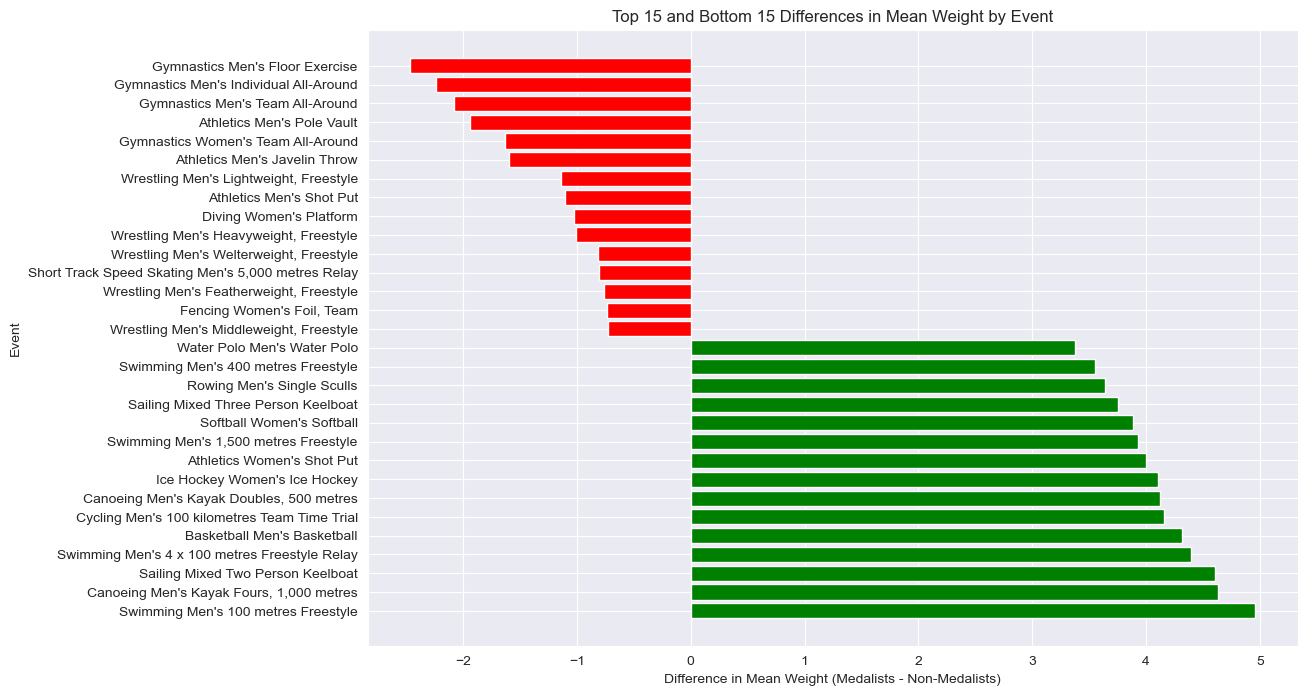

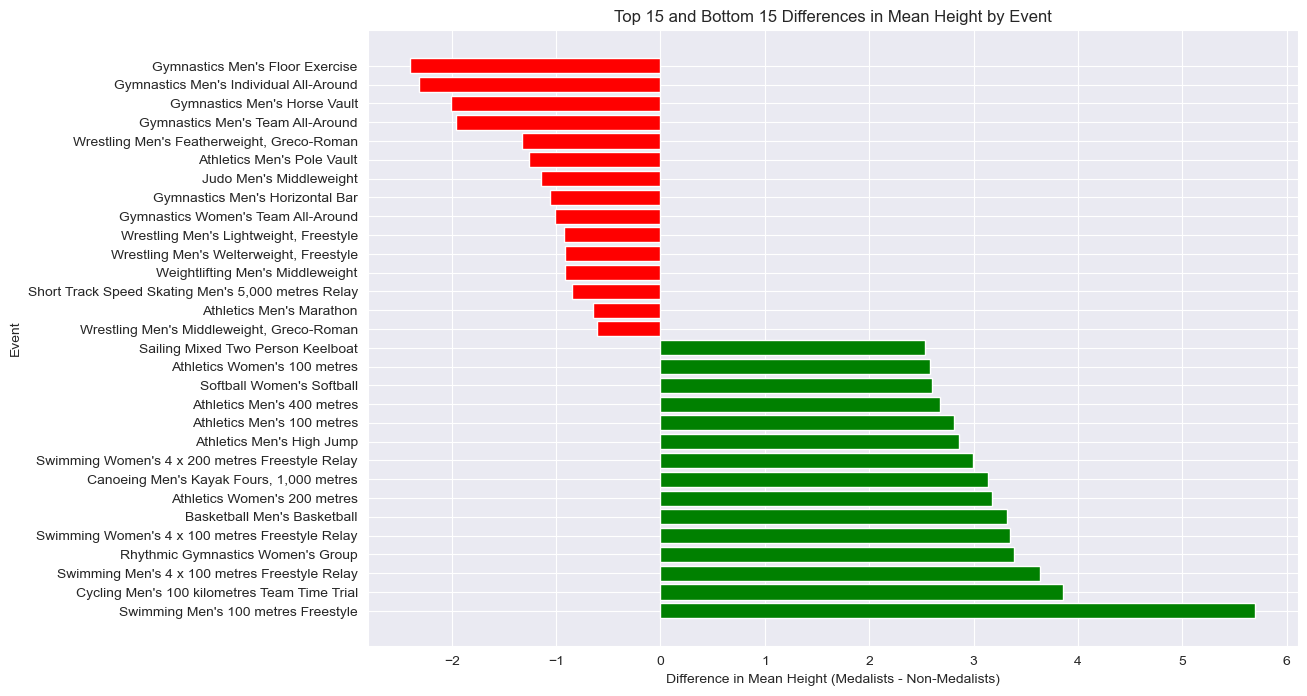

In [15]:
'''
Visualization of the Top and Bottom 10 Events for where Height and Weight's are factors in medaling
'''
merged_df = merged_df.sort_values(by="diff", ascending = True)
# Select the bottom 10 and top 10 differences
bottom_15 = merged_df.head(15)
top_15 = merged_df.tail(15)
# Concatenate the top and bottom 10 into a single DataFrame
combined_df = pd.concat([bottom_15, top_15])
combined_df = combined_df.sort_values(by="diff", ascending=False)
# Create a bar plot
plt.figure(figsize=(12, 8))
plt.barh(combined_df.index, combined_df["diff"], color=['red' if x < 0 else 'green' for x in combined_df["diff"]])
# Add labels and title
plt.xlabel('Difference in Mean Weight (Medalists - Non-Medalists)')
plt.ylabel('Event')
plt.title('Top 15 and Bottom 15 Differences in Mean Weight by Event')
# Display the plot
plt.show()

### Now for Height
# Select the bottom 10 and top 10 differences
merged_df2 = merged_df2.sort_values(by="diff", ascending = True)
bottom2_15 = merged_df2.head(15)
top2_15 = merged_df2.tail(15)
# Concatenate the top and bottom 10 into a single DataFrame
combined_df2 = pd.concat([bottom2_15, top2_15])
combined_df2 = combined_df2.sort_values(by="diff", ascending=False)
# Create a bar plot
plt.figure(figsize=(12, 8))
plt.barh(combined_df2.index, combined_df2["diff"], color=['red' if x < 0 else 'green' for x in combined_df2["diff"]])
# Add labels and title
plt.xlabel('Difference in Mean Height (Medalists - Non-Medalists)')
plt.ylabel('Event')
plt.title('Top 15 and Bottom 15 Differences in Mean Height by Event')
# Display the plot
plt.show()

As we can see in these figures, certain events such as gymnastics and wrestling usually have lighter and shorter medalists than non-medalists. While, the Swimming 100 meter freestyle, Cycling Men's 100km, Men's Basketball, etc. usually have taller and heavier medalists than non-medalists. 

### Creating the Models
For our models, we will have different use cases. We will test for seperately for events where Height/Weight is a factor, and for events where Height/Weight is not a factor. To do this we select the Swimming's Men's 100 metres Freestyle, and the Gymnastics Floor Exercise to test our models on data we already know is biased. Secondly, we will select from the middle of the dataframe to create a model that works best on an event where height/weight is not as important. Hopefully, with these methods we will be able to create space where we can accurately model different events. 

In [24]:
### The Swimming subset of the data
swimming_df = subset_enough_winners[subset_enough_winners['Event'] == "Swimming Men's 100 metres Freestyle"]
swimming_df.head()

,Sex,Age,Height,Weight,NOC,Year,Sport,Event,Medal
244,0,26.0,170.0,70.0,IRQ,2004,Swimming,Swimming Men's 100 metres Freestyle,0
551,0,24.0,181.0,73.0,PHI,1968,Swimming,Swimming Men's 100 metres Freestyle,0
751,0,20.0,180.0,74.0,SRI,2016,Swimming,Swimming Men's 100 metres Freestyle,0
1022,0,19.0,177.0,64.0,POR,1980,Swimming,Swimming Men's 100 metres Freestyle,0
1344,0,22.0,190.0,80.0,MRI,2008,Swimming,Swimming Men's 100 metres Freestyle,0


In [20]:
### The Gymnastics subset of the data
gymnastics_df = subset_enough_winners[subset_enough_winners['Event'] == "Gymnastics Men's Floor Exercise"]
gymnastics_df.describe()

,Sex,Age,Height,Weight,Year,Medal
count,1376.0,1376.000000,1376.000000,1376.000000,1376.000000,1376.000000
mean,0.0,23.716570,167.587209,63.317587,1983.447674,0.037064
std,0.0,3.542928,5.347389,5.547495,18.695731,0.188987
min,0.0,16.000000,150.000000,46.000000,1932.000000,0.000000
25%,0.0,21.000000,164.000000,60.000000,1968.000000,0.000000
50%,0.0,23.000000,168.000000,63.500000,1984.000000,0.000000
75%,0.0,26.000000,171.000000,67.000000,2000.000000,0.000000
max,0.0,44.000000,185.000000,87.000000,2016.000000,1.000000


In [ ]:
'''
TO-DO
'''
### One More df for an event, preferably female sport

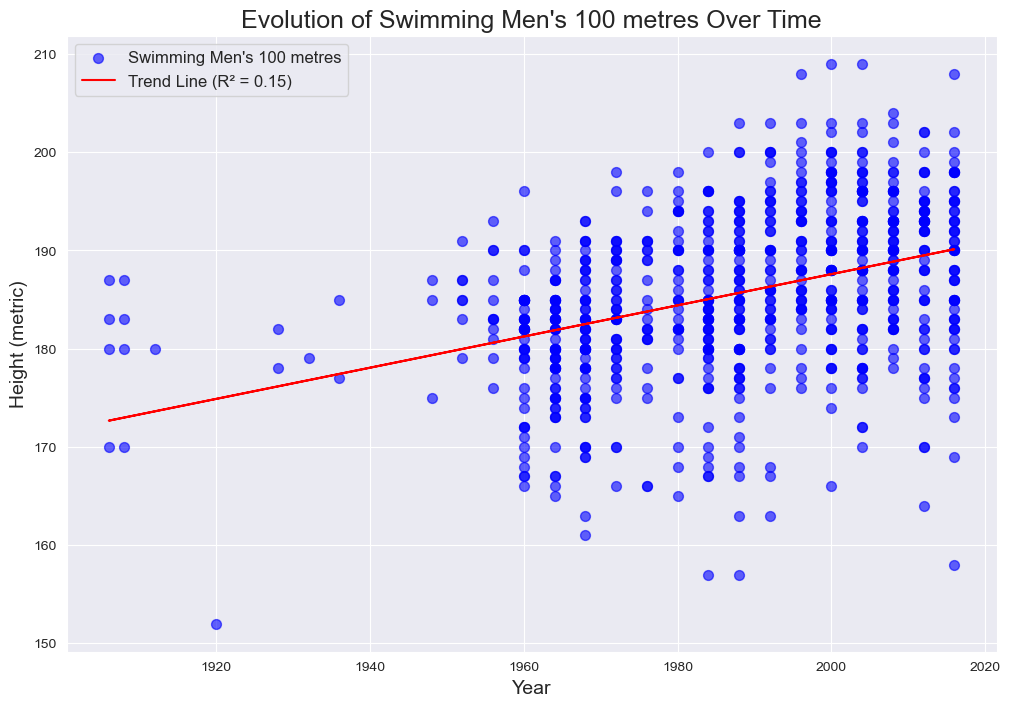

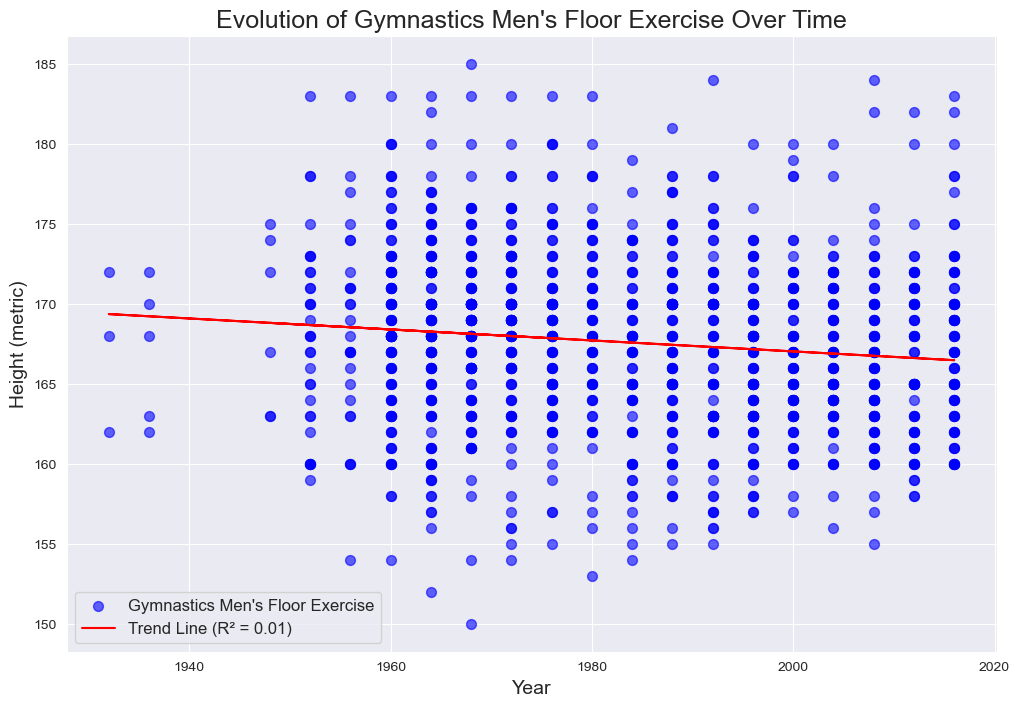

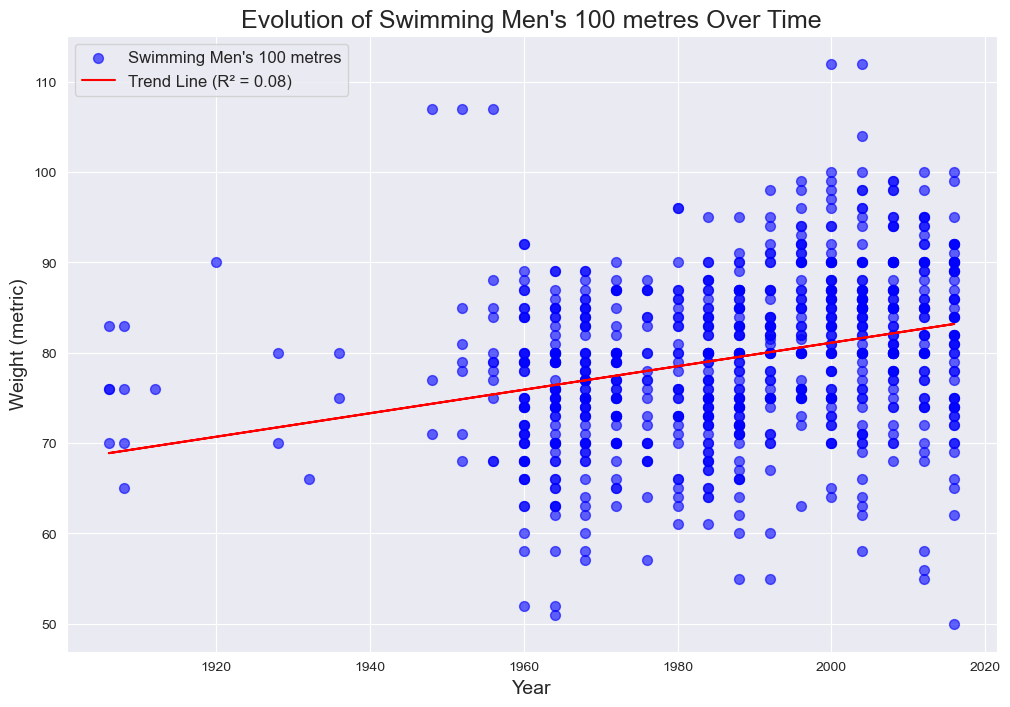

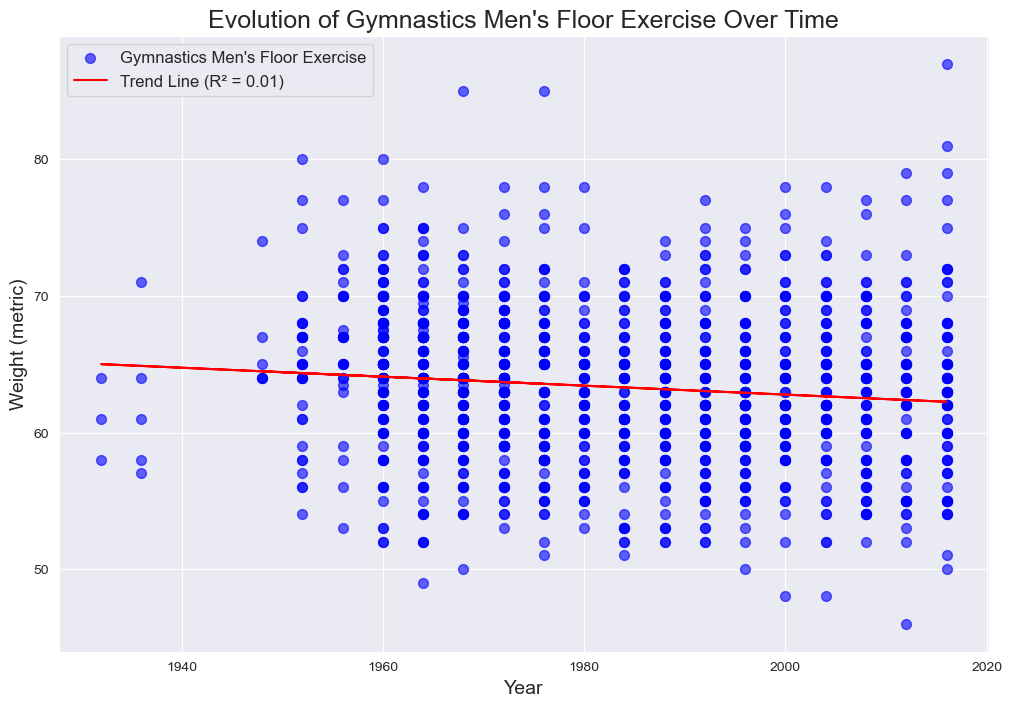

In [33]:
### It is interesting to check to see how these sports evolved over time to see Evolutionary Game Theory in action, so let's create a method to plot this
def plot_evolution(df, h_or_w, event_name):
    """
    Generates a plot showing the evolution of height over time.
    :param h_or_w: either height or weight
    :param df: DataFrame containing the data with columns "Year" and "Height".
    :param event_name: Name of the event.
    """
    plt.figure(figsize=(12, 8))
    
    # Scatter plot
    plt.scatter(df["Year"], df[h_or_w], label=event_name, color='blue', s=50, alpha=0.6)

    # Add a regression line
    slope, intercept, r_value, p_value, std_err = linregress(df["Year"], df[h_or_w])
    plt.plot(df["Year"], intercept + slope * df["Year"], 'r', label=f'Trend Line (R² = {r_value**2:.2f})')

    # Customize the plot
    plt.title(f"Evolution of {event_name} Over Time", fontsize=18)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel(f"{h_or_w} (metric)", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Show the plot
    plt.show()

plot_evolution(swimming_df,"Height", "Swimming Men's 100 metres")
plot_evolution(gymnastics_df,"Height", "Gymnastics Men's Floor Exercise")
plot_evolution(swimming_df,"Weight", "Swimming Men's 100 metres")
plot_evolution(gymnastics_df,"Weight", "Gymnastics Men's Floor Exercise")

Positive slope and negative slope, shows it has been selected for in athletes at the olympics over time. (This is not even for just the medalists. Let's take a look at that real quick

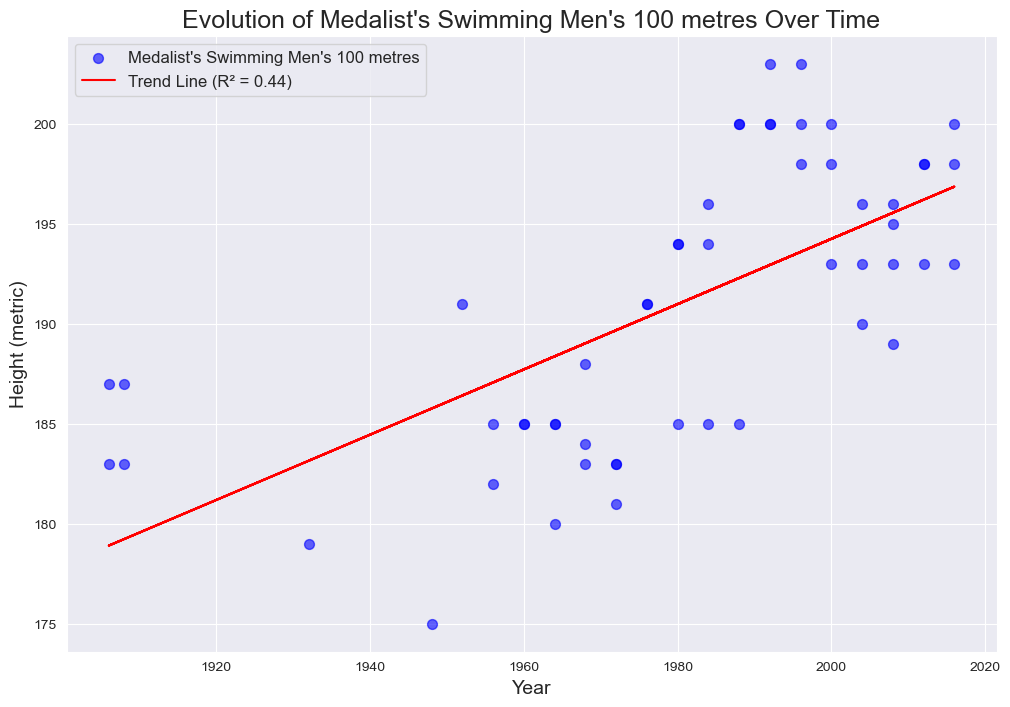

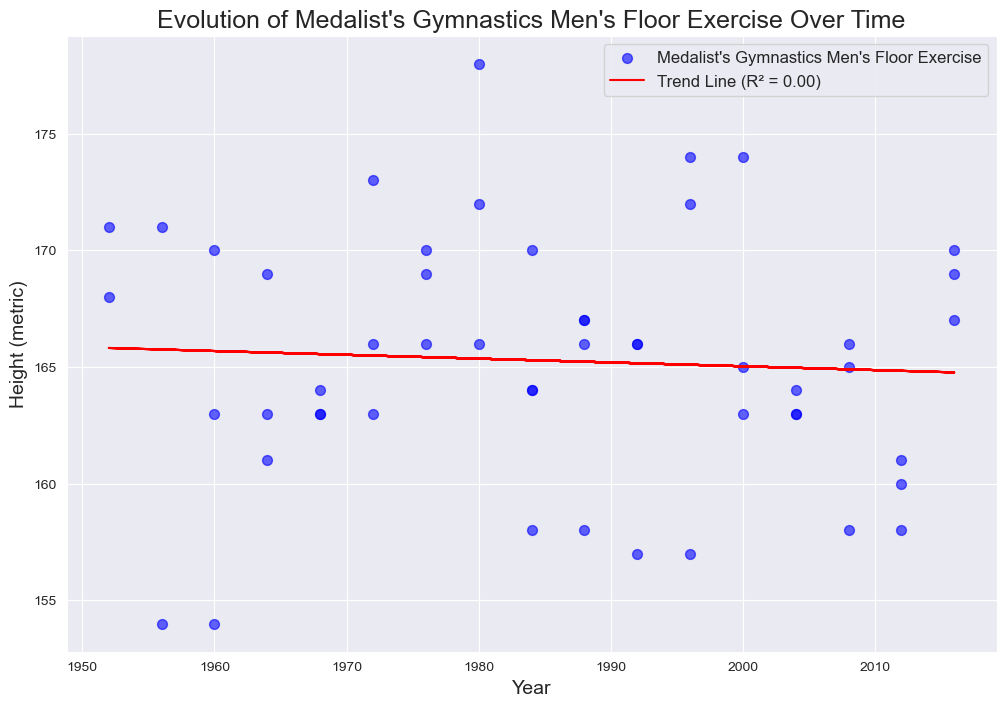

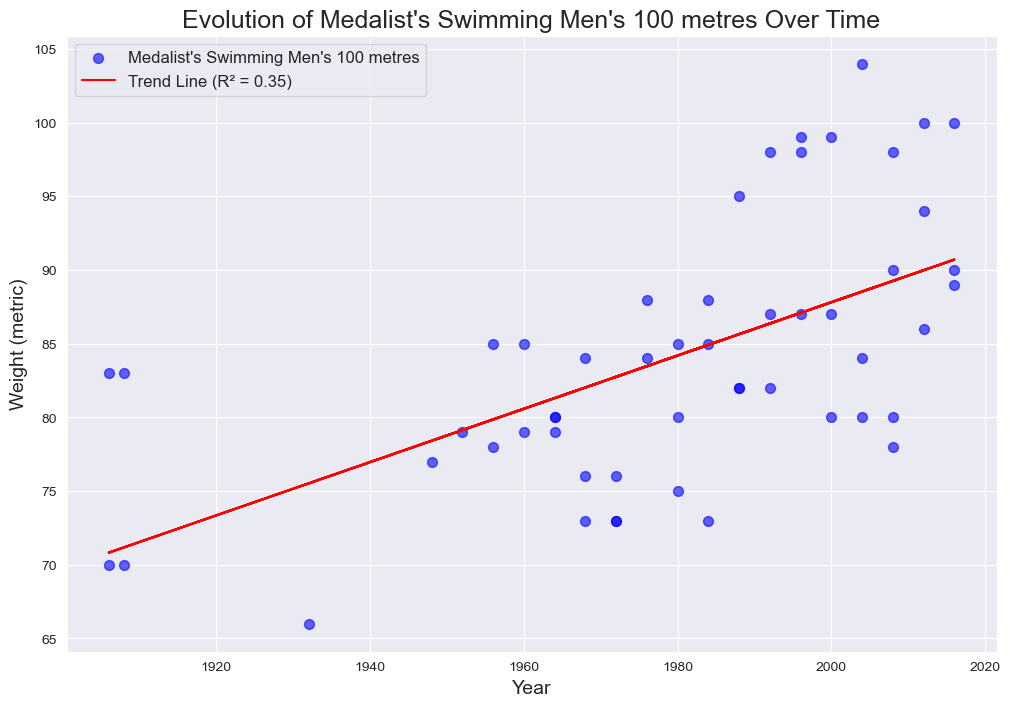

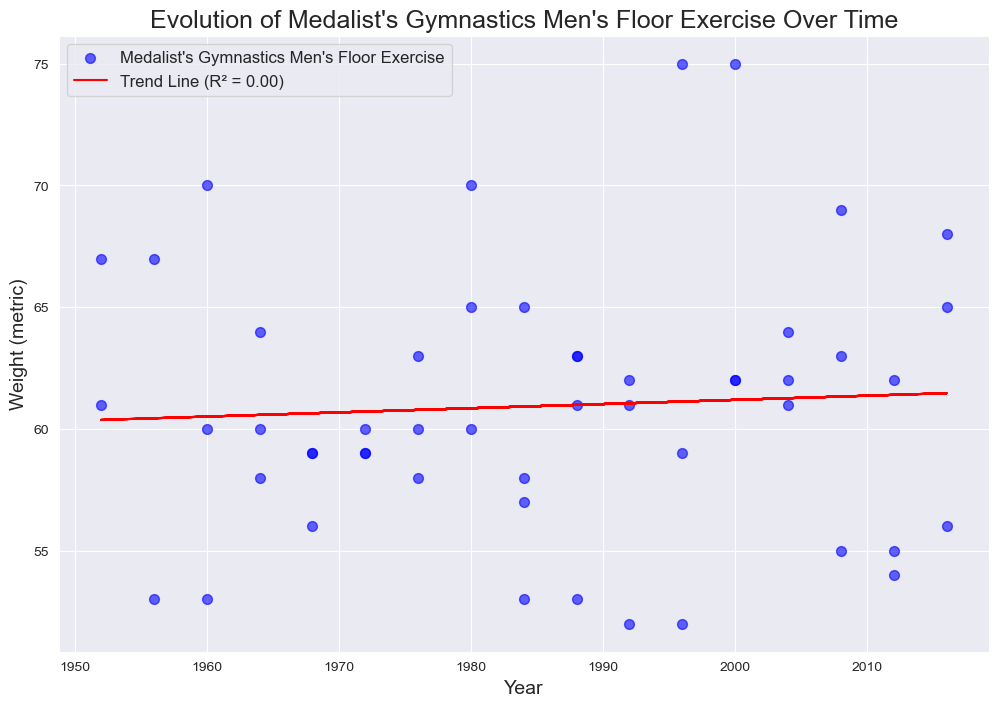

In [34]:
medal_swimming_df = swimming_df[swimming_df["Medal"]== 1]
medal_gymnastics_df = gymnastics_df[gymnastics_df["Medal"]== 1]
plot_evolution(medal_swimming_df,"Height", "Medalist's Swimming Men's 100 metres")
plot_evolution(medal_gymnastics_df,"Height", "Medalist's Gymnastics Men's Floor Exercise")
plot_evolution(medal_swimming_df,"Weight", "Medalist's Swimming Men's 100 metres")
plot_evolution(medal_gymnastics_df,"Weight", "Medalist's Gymnastics Men's Floor Exercise")

Far more correlated in swimming! While Gymnastics have been relatively steady over time (might be due to world's population getting slightly taller over time?)

## Model time
### Below is Logistic Regression, excluding Geographic data for now

In [53]:
## Imports specific for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_class_weight
'''
Here I created methods for each model so we can run them fairly quickly for different datasets
'''
def logistic_regression_model(df, feature_cols, target_col, test_size=0.3, random_state=42):
    """
    Training a Logistic Regression model
    :param df: DataFrame containing the data.
    :param feature_cols: List of column names to be used as features.
    :param target_col: Name of the target column.
    :param test_size: Proportion of data to be used for testing (default 0.3).
    :param random_state: Seed for train-test split (default 42).
    """
    # Splitting the data
    X = df[feature_cols]
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Standardizing the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Equally weighting 0 and 1 
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    model = LogisticRegression(class_weight=dict(enumerate(class_weights)))
    model.fit(X_train, y_train)

    # Making predictions
    y_pred = model.predict(X_test)

    # Model evaluation
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title("Logistic Regression - Confusion Matrix")
    plt.show()
    
    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5)  # 5-fold cross-validation
    print(f"Cross-Validation Accuracy: {scores.mean():.2f} ± {scores.std():.2f}")
    # If the feature space is 2D, visualize decision boundary
    if X_train.shape[1] == 2:
        plot_decision_boundary(X_train, y_train, model, title=f"Logistic Regression - Decision Boundary for {df['Event'].values[0]}")

def plot_decision_boundary(X, y, model, title):
    """
    Plots the decision boundary for a binary classifier
    :param X: Features (must be 2D).
    :param y: Target values.
    :param model: Trained model.
    :param title: Title for the plot.
    """
    h = .02  # step size in the mesh

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

Accuracy: 0.60
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.59      0.73       234
           1       0.12      0.62      0.20        21

    accuracy                           0.60       255
   macro avg       0.53      0.61      0.47       255
weighted avg       0.88      0.60      0.69       255



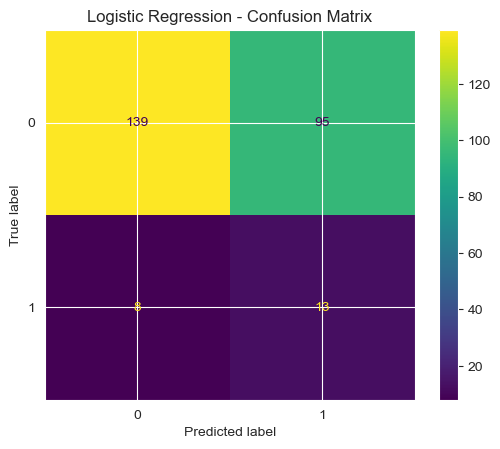

Cross-Validation Accuracy: 0.61 ± 0.05


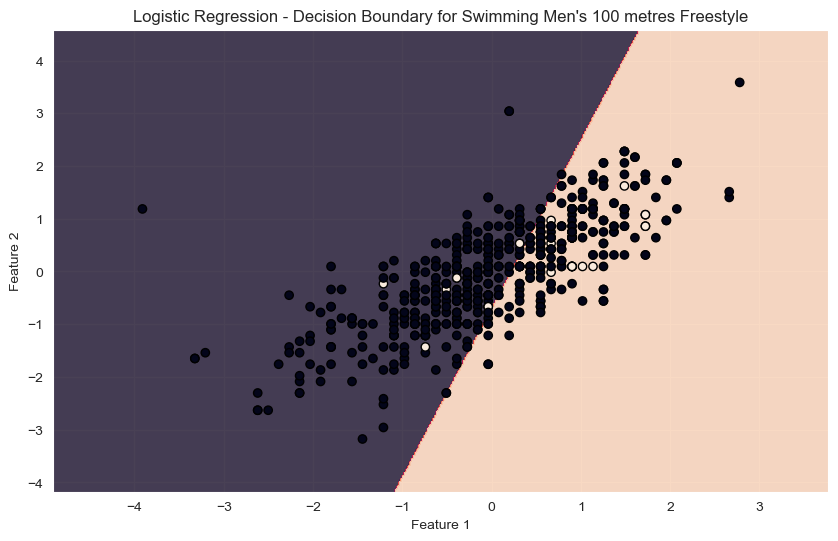

Accuracy: 0.62
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.62      0.76       399
           1       0.05      0.57      0.09        14

    accuracy                           0.62       413
   macro avg       0.51      0.60      0.43       413
weighted avg       0.94      0.62      0.74       413



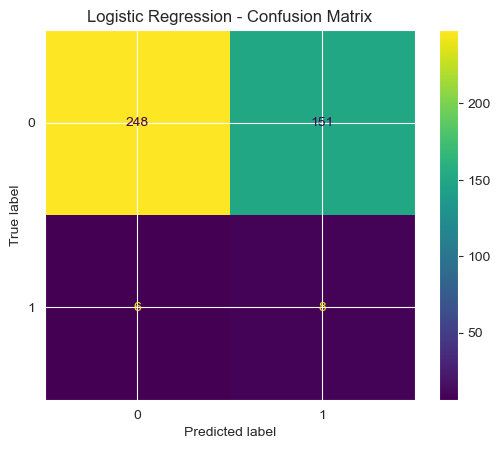

Cross-Validation Accuracy: 0.61 ± 0.03


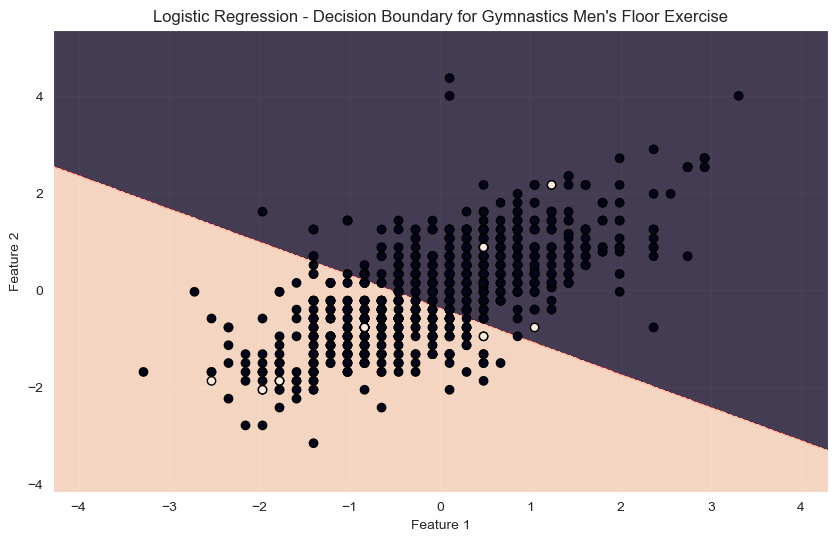

In [54]:
'''
Might need to Implement Reduce medals here
'''
### Let's call the logistic regression model for swimming
logistic_regression_model(swimming_df, feature_cols=['Height', 'Weight'], target_col='Medal')
logistic_regression_model(gymnastics_df, feature_cols=['Height', 'Weight'], target_col='Medal')

### SVM Model excluding Geographic Data

In [55]:
### Now to try an SVM model
from sklearn.svm import SVC

def svm_model(df, feature_cols, target_col, test_size=0.3, random_state=42, kernel='linear'):
    """
    Trains an SVM model + visuals
    :param df: DataFrame containing the data, in this case the events
    :param feature_cols: List of column names to be used as features.
    :param target_col: Name of the target column.
    :param test_size: Proportion of data to be used for testing (default 0.3).
    :param random_state: Seed for train-test split (default 42).
    :param kernel: Kernel type for SVM (default 'linear').
    """
    # Splitting the data
    X = df[feature_cols]
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Standardizing the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    
    # Creating and training the SVM model
    model = SVC(kernel=kernel, probability=True, class_weight='balanced')
    model.fit(X_train, y_train)

    # Making predictions
    y_pred = model.predict(X_test)

    # Model evaluation
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"SVM ({kernel}) - Confusion Matrix")
    plt.show()

    # If the feature space is 2D, visualize decision boundary
    if X_train.shape[1] == 2:
        plot_decision_boundary(X_train, y_train, model, title=f"SVM ({kernel}) - Decision Boundary for {df['Event'].values[0]}")


Accuracy: 0.53
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.51      0.67       234
           1       0.12      0.76      0.21        21

    accuracy                           0.53       255
   macro avg       0.54      0.64      0.44       255
weighted avg       0.89      0.53      0.63       255



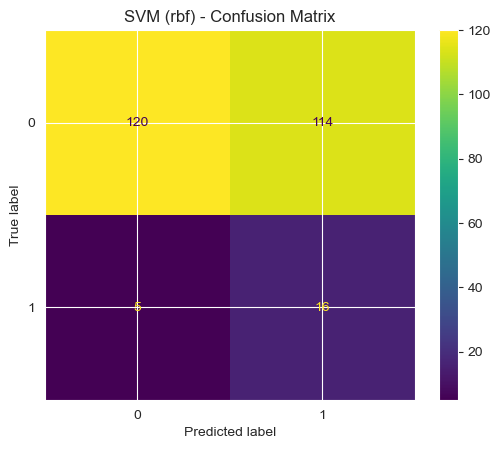

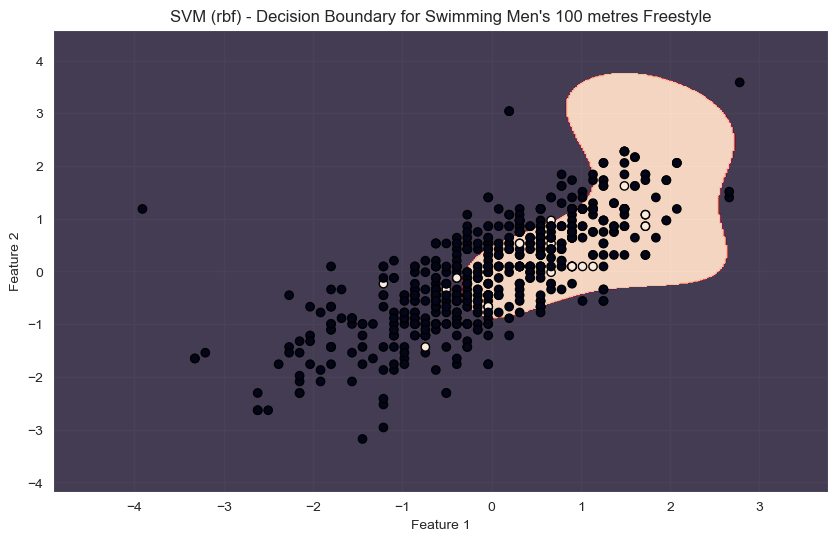

Accuracy: 0.59
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.58      0.73       399
           1       0.06      0.79      0.12        14

    accuracy                           0.59       413
   macro avg       0.52      0.68      0.42       413
weighted avg       0.96      0.59      0.71       413



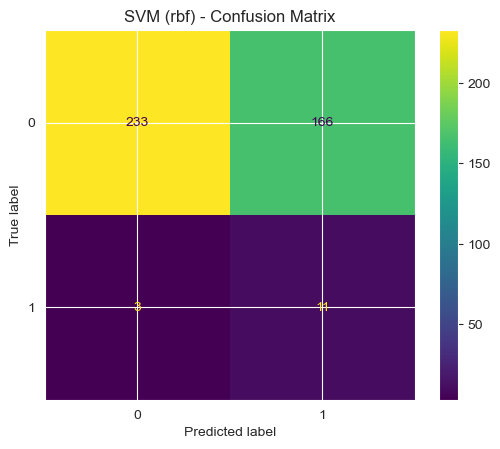

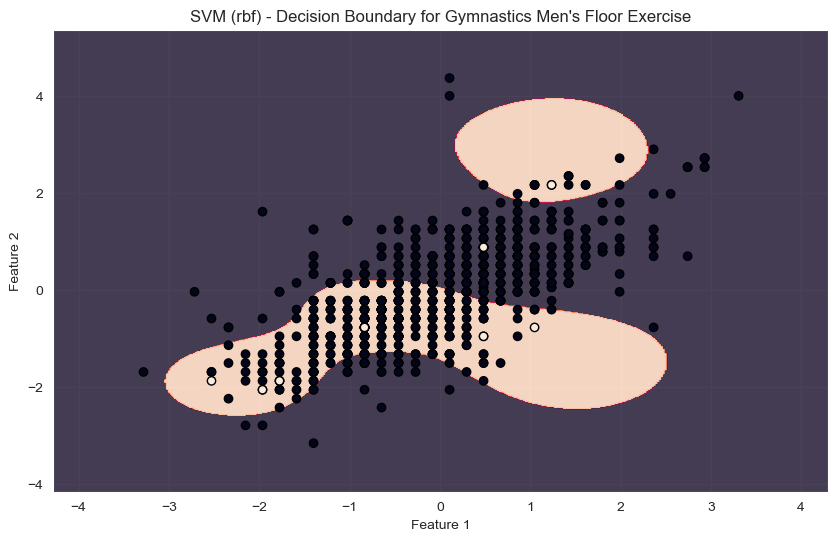

In [56]:
## Calling the SVM
svm_model(swimming_df, feature_cols=['Height', 'Weight'], target_col='Medal', kernel='rbf')
svm_model(gymnastics_df, feature_cols=['Height', 'Weight'], target_col='Medal', kernel='rbf')

### Decision Tree

In [76]:
from sklearn import tree
from sklearn.metrics import precision_score, recall_score, f1_score

def decision_tree_model(df, feature_cols, target_col):
    X = df[feature_cols]
    y = df[target_col]
    
    leaf_nodes = []
    scores = []

    # Test different numbers of leaf nodes
    for n_leaf_nodes in range(10, 201, 10):
        dtc_test = DecisionTreeClassifier(max_leaf_nodes=n_leaf_nodes, class_weight='balanced')
        dtc_test.fit(X, y)
        y_pred = dtc_test.predict(X)
        precision = precision_score(y, y_pred, pos_label=1)
        #add the scores into an array
        leaf_nodes.append(n_leaf_nodes)
        scores.append(precision)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(leaf_nodes, scores, marker='o')
    plt.xlabel('Number of Leaf Nodes')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Leaf Nodes')
    plt.grid(True)
    plt.show()
    # Find the index of the maximum accuracy
    best_index = scores.index(max(scores))
    best_leaf_nodes = leaf_nodes[best_index]
    best_score = scores[best_index]
    print("Best Number of Leaf Nodes:", best_leaf_nodes)
    print("Best Precision Score:", best_score)
    # Model
    model = DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=best_leaf_nodes)
    model.fit(X, y)
    
    y_pred = model.predict(X)
    print("Decision Tree Classification Report:")
    print(classification_report(y, y_pred))
    
    class_names = list(map(str, model.classes_))
    # Plot decision tree
    plt.figure(figsize=(20,10))
    tree.plot_tree(model, feature_names=feature_cols, class_names=class_names, filled=True)
    plt.title("Decision Tree")
    plt.show()
    
    return model

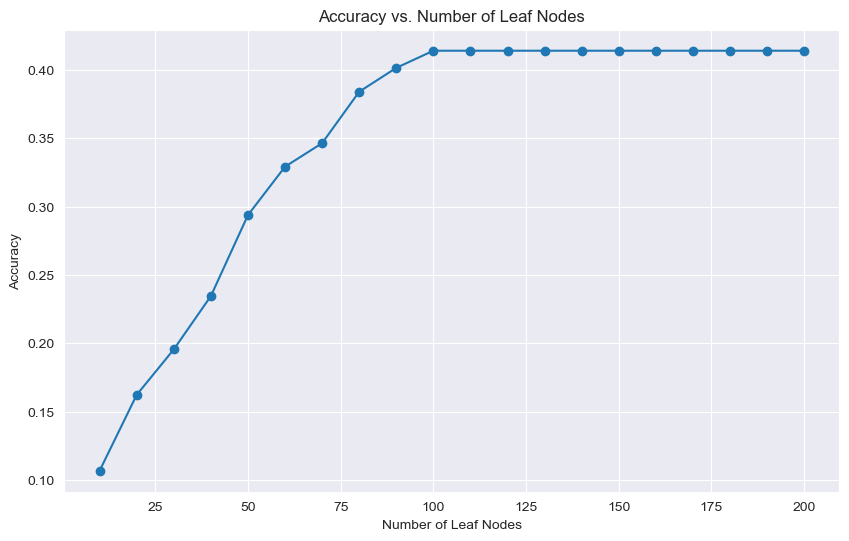

Best Number of Leaf Nodes: 100
Best Accuracy Score: 0.4140625
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       797
           1       0.41      1.00      0.59        53

    accuracy                           0.91       850
   macro avg       0.71      0.95      0.77       850
weighted avg       0.96      0.91      0.93       850



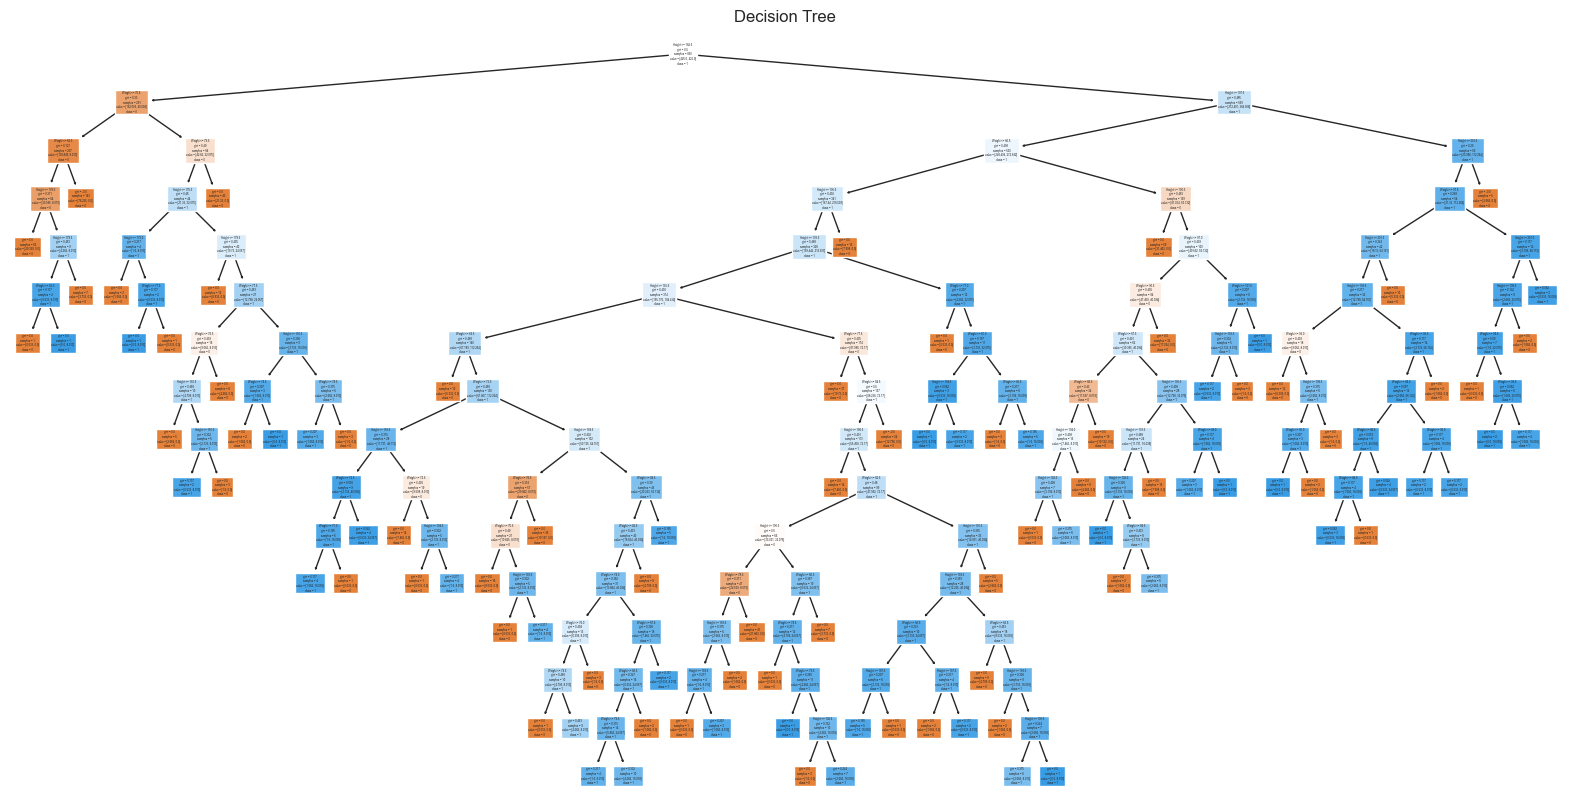

In [77]:
dtc = decision_tree_model(swimming_df, feature_cols=['Height', 'Weight'], target_col='Medal')

In [65]:
print(export_text(dtc))

|--- feature_0 <= 182.50
|   |--- feature_1 <= 75.50
|   |   |--- feature_1 <= 66.50
|   |   |   |--- feature_0 <= 178.50
|   |   |   |   |--- class: 0
|   |   |   |--- feature_0 >  178.50
|   |   |   |   |--- feature_0 <= 179.50
|   |   |   |   |   |--- feature_1 <= 65.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_1 >  65.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_0 >  179.50
|   |   |   |   |   |--- class: 0
|   |   |--- feature_1 >  66.50
|   |   |   |--- class: 0
|   |--- feature_1 >  75.50
|   |   |--- feature_1 <= 79.50
|   |   |   |--- feature_0 <= 175.50
|   |   |   |   |--- feature_0 <= 173.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_0 >  173.00
|   |   |   |   |   |--- feature_1 <= 77.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_1 >  77.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- feature_0 >  175.50
|   |   |   |   |--- feature_0 <= 179.50
|   |   |   |   | 

### Bagging

In [80]:
def bagging_model(df, feature_cols, target_col):    ## Bagging model method
    X = df[feature_cols]
    y = df[target_col]
    
    model = BaggingClassifier(estimator=dtc)
    model.fit(X, y)
    
    y_pred = model.predict(X)
    print("Bagging Classification Report:")
    print(classification_report(y, y_pred))
    
    return model

In [81]:
bagging_model(swimming_df, feature_cols=['Height', 'Weight'], target_col='Medal')

Bagging Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.96       797
           1       0.43      0.85      0.57        53

    accuracy                           0.92       850
   macro avg       0.71      0.89      0.76       850
weighted avg       0.95      0.92      0.93       850



BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                   max_leaf_nodes=100))

### Boosting

In [82]:
def boosting_model(df, feature_cols, target_col):
    X = df[feature_cols]
    y = df[target_col]
    
    model = GradientBoostingClassifier()
    model.fit(X, y)
    
    y_pred = model.predict(X)
    print("Boosting Classification Report:")
    print(classification_report(y, y_pred))
    
    return model

In [83]:
boosting_model(swimming_df, feature_cols=['Height', 'Weight'], target_col='Medal')

Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       797
           1       0.74      0.26      0.39        53

    accuracy                           0.95       850
   macro avg       0.84      0.63      0.68       850
weighted avg       0.94      0.95      0.94       850



GradientBoostingClassifier()

### Random Forest

In [84]:
def random_forest_model(df, feature_cols, target_col):
    X = df[feature_cols]
    y = df[target_col]
    
    model = RandomForestClassifier()
    model.fit(X, y)
    
    y_pred = model.predict(X)
    print("Random Forest Classification Report:")
    print(classification_report(y, y_pred))
    
    # Feature importances plot
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), np.array(feature_cols)[indices], rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
    return model

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       797
           1       0.80      0.45      0.58        53

    accuracy                           0.96       850
   macro avg       0.88      0.72      0.78       850
weighted avg       0.95      0.96      0.95       850



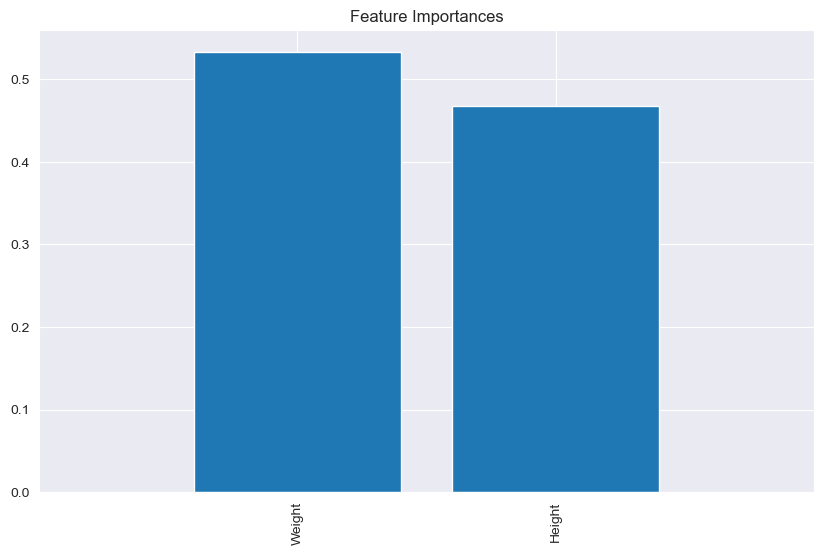

RandomForestClassifier()

In [85]:
random_forest_model(swimming_df, feature_cols=['Height', 'Weight'], target_col='Medal')

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1325
           1       0.91      0.20      0.32        51

    accuracy                           0.97      1376
   macro avg       0.94      0.60      0.65      1376
weighted avg       0.97      0.97      0.96      1376



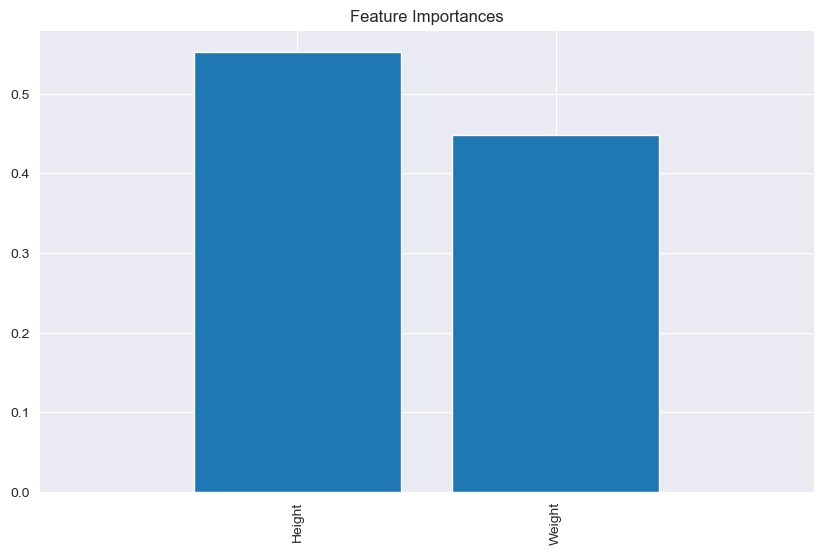

RandomForestClassifier()

In [86]:
random_forest_model(gymnastics_df, feature_cols=['Height', 'Weight'], target_col='Medal')

Wow! Cool to see that Height has more importance than weight in gymnastics but opposite in swimming, but both are very important nonethless.